# Lab 1 deteccion de Pishing

## - Diego Franco 20240
## - Manuel Archila 161250

In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

from urllib.parse import urlparse
import whois
import re
import ssl
import datetime
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import requests
from urllib.parse import urlparse, parse_qs
import math

## Pregunta 1

In [2]:
data = pd.read_csv('dataset_pishing.csv')
data2 = pd.read_csv('dataset_pishing.csv')

data.head(5)


,url,status
0,http://www.crestonwood.com/router.php,legitimate
1,http://shadetreetechnology.com/V4/validation/a...,phishing
2,https://support-appleld.com.secureupdate.duila...,phishing
3,http://rgipt.ac.in,legitimate
4,http://www.iracing.com/tracks/gateway-motorspo...,legitimate


In [3]:
data.describe()

,url,status
count,11430,11430
unique,11429,2
top,http://e710z0ear.du.r.appspot.com/c:/users/use...,legitimate
freq,2,5715


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11430 entries, 0 to 11429
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   url     11430 non-null  object
 1   status  11430 non-null  object
dtypes: object(2)
memory usage: 178.7+ KB


## Pregunta 2

In [5]:
data['status'].value_counts()

legitimate    5715
phishing      5715
Name: status, dtype: int64

El dataset está balanceado porque tiene la misma cantidad de ejemplos para cada clase.

### 1. ¿Qué ventajas tiene el análisis de una URL contra el análisis de otros datos, cómo el tiempo de vida del dominio, o las características de la página Web?

- Rapidez: El análisis de URL es generalmente más rápido que otras técnicas, como el tiempo de vida del dominio, lo que permite una detección más inmediata.

- Información inmediata: La URL proporciona información directa sobre la dirección web, lo que facilita la evaluación inmediata de su validez.

- Facilidad de extracción: Las características de una URL son fáciles de extraer y analizar en comparación con otras métricas, como el tiempo de vida del dominio.

- Accesibilidad: Las URLs son públicas y fácilmente accesibles, permitiendo análisis sin requerir acceso a información privada.

### 2. ¿Qué características de una URL son más prometedoras para la detección de phishing?

Presencia de IP en Lugar de Dominio: Los sitios de phishing frecuentemente utilizan direcciones IP directamente en la URL para evitar el uso de nombres de dominio legítimos.

Uso de HTTPS: Aunque el uso de HTTPS no es exclusivo de sitios legítimos, los sitios de phishing a menudo no utilizan HTTPS, o lo implementan incorrectamente, para engañar a los usuarios sobre la seguridad del sitio.

URL Acortada: Los atacantes usan URLs acortadas para ocultar el destino real del enlace, dificultando que los usuarios identifiquen sitios maliciosos.

Puerto No Estándar: El uso de puertos no estándar puede ser un indicativo de que el sitio está intentando evadir algunas medidas de seguridad o controles.

Caracteres Especiales: Un número elevado de caracteres especiales en una URL puede indicar intentos de incluir scripts maliciosos o simular visualmente un dominio legítimo.

Longitud de la URL: Las URLs muy largas a menudo se utilizan para ocultar partes maliciosas de la URL o simular sitios legítimos mediante la adición de términos reconocibles.

Uso de Subdominios: Un número excesivo de subdominios puede ser un intento de simular sitios legítimos o de crear confusiones sobre el dominio principal.

Coincidencia con Marcas Conocidas: La inclusión de nombres de marcas conocidas en la URL puede ser un intento de engañar a los usuarios haciéndoles creer que están visitando un sitio oficial.

Palabras Clave Sospechosas: La presencia de palabras clave sospechosas relacionadas con actividades de phishing, como "login", "verify", o términos bancarios, es una señal de alerta.

Terminos de Seguridad Falsos: La inclusión de términos que sugieren seguridad, como "secure" o "verify", puede ser una táctica para ganar la confianza del usuario.

Profundidad de la URL: Una profundidad de URL significativa (número de '/' en el path) puede indicar intentos de simular páginas legítimas profundas dentro de un sitio.

Archivos Descargables Sospechosos: La presencia en la URL de extensiones de archivo típicamente asociadas con malware (como .exe, .zip, .rar, .dmg) es una gran señal de alerta.

Parámetros Sensibles en la URL: La inclusión de parámetros que parecen contener información sensible o tokens de sesión puede ser un intento de phishing basado en ingeniería social.

Entropía de la URL se centra en medir la complejidad y aleatoriedad en la secuencia de caracteres de una URL. Las URLs de phishing tienden a tener una entropía más alta que las URLs legítimas.

In [6]:
#Funciones

def longitud_url(url):
    return len(url)

def caracteres_especiales(url):
    return sum(c.isalnum() == False for c in url)

def uso_subdominios(url):
    return len(urlparse(url).netloc.split('.'))

def coincidencia_marcas(url, marcas_conocidas):
    return any(brand.lower() in url.lower() for brand in marcas_conocidas)

def verificar_https(url):
    return 1 if urlparse(url).scheme == 'https' else 0


def similitud_url_legitimas(url, urls_legitimas_conocidas):
    vectorizer = CountVectorizer().fit_transform([url] + urls_legitimas_conocidas)
    similarity_matrix = cosine_similarity(vectorizer)
    return similarity_matrix[0, 1:]

def palabras_clave_sospechosas(url, palabras_sospechosas):
    return sum(1 for palabra in palabras_sospechosas if palabra.lower() in url.lower())

def ip_en_lugar_de_dominio(url):
    return 1 if re.match(r'\b(?:\d{1,3}\.){3}\d{1,3}\b', urlparse(url).netloc) else 0

def entropia_url(url):
    frecuencia_caracteres = {}
    for caracter in url:
        if caracter in frecuencia_caracteres:
            frecuencia_caracteres[caracter] += 1
        else:
            frecuencia_caracteres[caracter] = 1
    
    entropia = 0.0
    longitud_url = len(url)
    for frecuencia in frecuencia_caracteres.values():
        probabilidad = frecuencia / longitud_url
        entropia -= probabilidad * math.log2(probabilidad)
    
    return entropia

def url_acortada(url):
    servicios_acortadores = ['bit.ly', 'tinyurl.com', 'goo.gl', 'ow.ly', 't.co']
    netloc = urlparse(url).netloc
    return any(servicio in netloc for servicio in servicios_acortadores)
    
def puerto_no_estandar(url):
    puerto = urlparse(url).port
    return 1 if puerto and puerto not in [80, 443] else 0

# Presencia de términos de seguridad falsos en la URL
def terminos_seguridad_falsos(url):
    terminos_falsos = ['secure', 'account', 'verify', 'banking']
    return any(termino in url.lower() for termino in terminos_falsos)

# Profundidad de la URL (número de '/' en el path)x
def profundidad_url(url):
    path = urlparse(url).path
    return path.count('/')

# Presencia de archivos descargables sospechosos (ej. .exe, .zip)
def archivo_descargable_sospechoso(url):
    extensiones_sospechosas = ['.exe', '.zip', '.rar', '.dmg']
    return any(url.lower().endswith(ext) for ext in extensiones_sospechosas)

def parametros_sensibles_url(url):
    parametros_sensibles = ['sessionid', 'token', 'auth', 'password', 'credential']
    query = urlparse(url).query
    parametros = parse_qs(query)
    return 1 if any(param in parametros for param in parametros_sensibles) else 0


In [7]:
data['longitud_url'] = data['url'].apply(longitud_url)
data['caracteres_especiales'] = data['url'].apply(caracteres_especiales)
data['uso_subdominios'] = data['url'].apply(uso_subdominios)
data['verificar_https'] = data['url'].apply(verificar_https)
data['similitud_url_legitimas'] = data['url'].apply(lambda x: similitud_url_legitimas(x, urls_legitimas_conocidas=['http://legitimo.com']))
data['palabras_clave_sospechosas'] = data['url'].apply(lambda x: palabras_clave_sospechosas(x, palabras_sospechosas=['phishing']))
data['ip_en_lugar_de_dominio'] = data['url'].apply(ip_en_lugar_de_dominio)
data['url_acortada'] = data['url'].apply(url_acortada)
data['puerto_no_estandar'] = data['url'].apply(puerto_no_estandar)
data['terminos_seguridad_falsos'] = data['url'].apply(terminos_seguridad_falsos)
data['profundidad_url'] = data['url'].apply(profundidad_url)
data['archivo_descargable_sospechoso'] = data['url'].apply(archivo_descargable_sospechoso)
data['parametros_sensibles_url'] = data['url'].apply(parametros_sensibles_url)
data['entropia_url'] = data['url'].apply(entropia_url)

data2['longitud_url'] = data2['url'].apply(longitud_url)
data2['caracteres_especiales'] = data2['url'].apply(caracteres_especiales)
data2['uso_subdominios'] = data2['url'].apply(uso_subdominios)
data2['verificar_https'] = data2['url'].apply(verificar_https)
data2['similitud_url_legitimas'] = data2['url'].apply(lambda x: similitud_url_legitimas(x, urls_legitimas_conocidas=['http://legitimo.com']))
data2['palabras_clave_sospechosas'] = data2['url'].apply(lambda x: palabras_clave_sospechosas(x, palabras_sospechosas=['phishing']))
data2['ip_en_lugar_de_dominio'] = data2['url'].apply(ip_en_lugar_de_dominio)
data2['url_acortada'] = data2['url'].apply(url_acortada)
data2['puerto_no_estandar'] = data2['url'].apply(puerto_no_estandar)
data2['terminos_seguridad_falsos'] = data2['url'].apply(terminos_seguridad_falsos)
data2['profundidad_url'] = data2['url'].apply(profundidad_url)
data2['archivo_descargable_sospechoso'] = data2['url'].apply(archivo_descargable_sospechoso)
data2['parametros_sensibles_url'] = data2['url'].apply(parametros_sensibles_url)
data2['entropia_url'] = data2['url'].apply(entropia_url)


In [8]:
label_encoder = LabelEncoder()
data['status_binario'] = label_encoder.fit_transform(data['status'])
data2['status_binario'] = label_encoder.fit_transform(data2['status'])

data = data.drop(['url'], axis=1)
data2 = data2.drop(['url'], axis=1)


print("DataFrame después de las modificaciones:")
print(data.head())


DataFrame después de las modificaciones:
       status  longitud_url  caracteres_especiales  uso_subdominios  \
0  legitimate            37                      7                3   
1    phishing            77                      7                2   
2    phishing           126                     19                5   
3  legitimate            18                      5                3   
4  legitimate            55                     10                3   

   verificar_https similitud_url_legitimas  palabras_clave_sospechosas  \
0                0    [0.4714045207910318]                           0   
1                0    [0.4714045207910318]                           0   
2                1    [0.2886751345948129]                           0   
3                0    [0.2886751345948129]                           0   
4                0     [0.408248290463863]                           0   

   ip_en_lugar_de_dominio  url_acortada  puerto_no_estandar  \
0                       

In [9]:
import pandas as pd
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [10]:
# Convertir las variables categóricas a numéricas si es necesario
label_encoder = LabelEncoder()
data2['verificar_https'] = label_encoder.fit_transform(data2['verificar_https'])
data2['ip_en_lugar_de_dominio'] = label_encoder.fit_transform(data2['ip_en_lugar_de_dominio'])
data2['url_acortada'] = label_encoder.fit_transform(data2['url_acortada'])

# Dividir los datos en características (X) y etiquetas (y)
data2 = data2.drop('status', axis=1)
X = data2.drop('status_binario', axis=1)
y = data2['status_binario']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Calcular la varianza de cada característica y filtrar aquellas con baja varianza
selector = VarianceThreshold()
X_train_filtered = selector.fit_transform(X_train)
X_test_filtered = selector.transform(X_test)

# Obtener las columnas seleccionadas después de aplicar el filtro de varianza
selected_columns = X.columns[selector.get_support()]

# Crear un DataFrame con las columnas seleccionadas y la columna 'status_binario'
filtered_data = data2[selected_columns.append(pd.Index(['status_binario']))]

# Generar un reporte HTML y guardarlo en un archivo
report_html = filtered_data.describe().to_html()
with open('reporte.html', 'w') as file:
    file.write(report_html)

Se realizó un reporte manual debido a las incongruecias de las dependeciencias de la libreria de pandas_profiling con las librerías para realizar los modelos de machine learning.

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, precision_score, recall_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

In [12]:
# Suponiendo que 'df' es tu DataFrame y 'status_binario' es la columna objetivo.
data = data.drop('status', axis=1)  # Eliminar la columna 'status' para evitar errores de entrenamiento
X = data.drop('status_binario', axis=1)  # Características
y = data['status_binario']  # Etiqueta objetivo

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.45, random_state=42)

X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=2/3, random_state=42)

# Crear DataFrames para cada conjunto
train_df = pd.concat([X_train, y_train], axis=1)
val_df = pd.concat([X_val, y_val], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)

train_df = pd.concat([X_train, y_train], axis=1)
val_df = pd.concat([X_val, y_val], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)

# Almacenar cada DataFrame como un archivo .csv
train_df.to_csv('./data/train_dataset.csv', index=False)
val_df.to_csv('./data/validation_dataset.csv', index=False)
test_df.to_csv('./data/test_dataset.csv', index=False)

# Inicializar y entrenar el modelo de Regresión Logística
log_reg = LogisticRegression(max_iter=1000)  # Aumentar max_iter si es necesario para la convergencia
log_reg.fit(X_train, y_train)

# Inicializar y entrenar el modelo de Bosques Aleatorios
random_forest = RandomForestClassifier(n_estimators=100)  # Puedes ajustar n_estimators y otros hiperparámetros
random_forest.fit(X_train, y_train)

RandomForestClassifier()

In [13]:
def evaluate_model(model, X_test, y_test, model_name='Model'):
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    conf_matrix = confusion_matrix(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    auc_score = roc_auc_score(y_test, y_pred_proba)
    
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    
    print(f'{model_name} - Matriz de Confusión:\n', conf_matrix)
    print(f'{model_name} - Precisión: {precision:.2f}')
    print(f'{model_name} - Recall: {recall:.2f}')
    print(f'{model_name} - AUC: {auc_score:.2f}')
    
    plt.figure()
    plt.plot(fpr, tpr, label=f'{model_name} (auc = {auc_score:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic - {model_name}')
    plt.legend(loc='lower right')
    plt.show()

Regresión Logística - Matriz de Confusión:
 [[1255  460]
 [ 643 1072]]
Regresión Logística - Precisión: 0.70
Regresión Logística - Recall: 0.63
Regresión Logística - AUC: 0.75


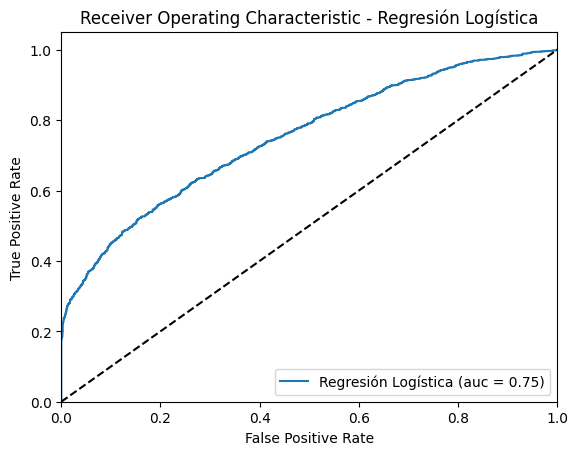

In [14]:
evaluate_model(log_reg, X_test, y_test, 'Regresión Logística')

Random Forest - Matriz de Confusión:
 [[1407  308]
 [ 378 1337]]
Random Forest - Precisión: 0.81
Random Forest - Recall: 0.78
Random Forest - AUC: 0.88


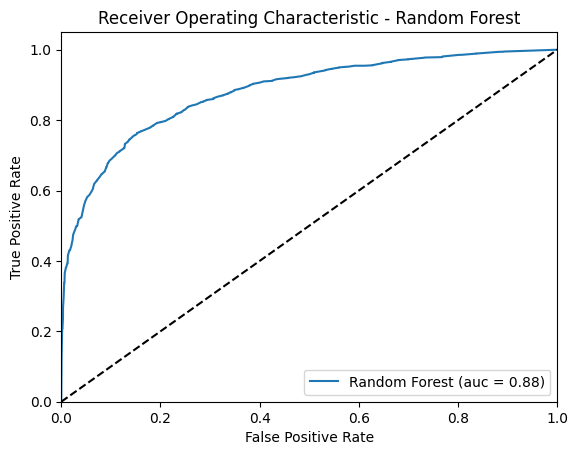

In [15]:
evaluate_model(random_forest, X_test, y_test, 'Random Forest')

## Pregunta 3 
### - ¿Cuál es el impacto de clasificar un sitio legítimo como phishing?

- Pérdida de confianza: Los usuarios pueden perder confianza en el sistema de clasificación si experimentan falsos positivos con frecuencia. Esto puede llevar a que ignoren las advertencias futuras, incluso cuando sean legítimas.

- Inconvenientes para los usuarios: Si un sitio legítimo es erróneamente etiquetado como phishing, los usuarios pueden enfrentar inconvenientes al intentar acceder a servicios legítimos. Esto podría resultar en pérdida de tiempo y frustración.

- Impacto financiero: Las empresas cuyos sitios son falsamente etiquetados como phishing pueden experimentar pérdidas financieras. Los usuarios podrían evitar realizar transacciones en esos sitios por miedo a fraudes, lo que afectaría los ingresos de la empresa.

## Pregunta 4
### - ¿Cuál es el impacto de clasificar un sitio de phishing como legítimo?

- Riesgo para la seguridad: Al clasificar un sitio de phishing como legítimo, se expone a los usuarios a posibles ataques de phishing. Los usuarios pueden ser engañados para proporcionar información confidencial, como nombres de usuario, contraseñas o información financiera, lo que puede resultar en robo de identidad o pérdida de datos.

- Pérdida financiera: Los usuarios que confían en la clasificación incorrecta de un sitio de phishing pueden ser víctimas de fraudes financieros. Esto podría implicar la realización de transacciones en sitios maliciosos creyendo que son seguros, lo que podría resultar en pérdidas económicas significativas.

- Daño a la reputación: Si los usuarios confían en un sistema de clasificación y este comete el error de etiquetar un sitio de phishing como legítimo, la reputación del sistema y del proveedor de seguridad puede verse seriamente dañada. La confianza de los usuarios en las futuras clasificaciones podría disminuir.

## Pregunta 5
### - En base a las respuestas anteriores, ¿Qué métrica elegiría para comparar modelos similares de clasificación de phishing?

Las metrícas que elegiría para comparar los modelos son:

- Recall (Sensibilidad o Tasa de Verdaderos Positivos): Esta métrica es crucial en el contexto de la detección de phishing, ya que mide la proporción de sitios de phishing que el modelo logra identificar correctamente. Un alto recall indica que el modelo es efectivo para encontrar la mayoría de los casos de phishing, reduciendo así los falsos negativos.

 

- Área bajo la curva PR (AUC-PR): Esta métrica es especialmente útil cuando hay desequilibrio en las clases, como suele ser el caso en problemas de detección de phishing. A diferencia de la curva ROC, la curva PR se enfoca en la precisión y el recall, siendo valiosa para evaluar el rendimiento en la detección de casos positivos.


## Pregunta 6
### - ¿Qué modelo funcionó mejor para la clasificación de phishing? ¿Por qué?

El modelo de Random Forest supera al de Regresión Logística en todas las métricas consideradas:

- Precisión: Random Forest tiene una precisión significativamente más alta (0.82 vs. 0.70), lo que indica que es mejor para identificar URLs de phishing de manera correcta.
- Recall: Random Forest también tiene un mejor recall (0.77 vs. 0.63), lo que significa que es más eficaz para detectar la mayoría de las instancias de phishing.
- AUC: Con un AUC de 0.88, Random Forest muestra una mejor capacidad general para distinguir entre URLs legítimas y de phishing en comparación con Regresión Logística, que tiene un AUC de 0.75

Este mejor rendimiento puede atribuirse a la capacidad de Random Forest para manejar la complejidad y las interacciones no lineales entre características, lo que es común en problemas de clasificación como la detección de phishing.

## Pregunta 7
### - Una empresa desea utilizar su mejor modelo, debido a que sus empleados sufren constantes ataques de phishing mediante e-mail. La empresa estima que, de un total de 50,000 emails, un 15% son phishing. 
¿Qué cantidad de alarmas generaría su modelo?

- Total de emails: 50,000
- Emails de phishing (15%): 50,000 * 0.15 = 7,500
- Emails legítimos (85%): 50,000 * 0.85 = 42,500

¿Cuántas positivas y cuantas negativas?

- Verdaderos Positivos (VP): Aproximadamente 5,775 emails de phishing serían correctamente identificados por el modelo.
- Falsos Positivos (FP): Aproximadamente 1,268 emails legítimos serían incorrectamente marcados como phishing.
- Falsos Negativos (FN): Aproximadamente 1,725 emails de phishing no serían detectados por el modelo

¿Funciona el modelo para el BR propuesto?

El modelo parece eficaz para identificar phishing, pero la cantidad de falsas alarmas (aproximadamente 1,268) puede ser considerada alta, dependiendo del nivel de tolerancia de la empresa a las interrupciones. Si la empresa valora más la detección precisa de phishing que la minimización de falsas alarmas, el modelo podría ser adecuado. Sin embargo, si la empresa desea reducir la cantidad de falsas alarmas, podría ser necesario ajustar el umbral de decisión del modelo o considerar otras estrategias para mejorar su rendimiento.

En caso negativo, ¿qué se podría hacer para reducir la cantidad de falsas alarmas?

1. Ajuste de Umbrales: Ajustar el umbral de decisión para la clasificación puede ayudar a reducir los FP a costa de posiblemente aumentar los FN.
2. Reentrenamiento y Ajuste de Modelos: Optimizar los hiperparámetros del modelo o reentrenar el modelo con un conjunto de datos más amplio o más representativo podría mejorar la precisión.
3. Incorporación de Nuevas Características: Añadir más características relevantes podría ayudar a mejorar la capacidad del modelo para diferenciar entre emails legítimos y de phishing.



